In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
from tqdm.notebook import tqdm
import time
import pickle
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import sem

In [3]:
from sklearn.metrics import make_scorer, confusion_matrix, roc_auc_score, roc_curve, plot_confusion_matrix, f1_score, recall_score, accuracy_score

from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_curve

In [52]:
FN = '/mnt/c/Users/conor/Git_Projects/PHD/results/New/2year_2306_2_year_normalize.pickle'

with open(FN, 'rb') as file_:

    results_dict = pickle.load(file_)#

results = pd.DataFrame(results_dict)

#results = pd.DataFrame(results_dict['Predictions'])
#trace = results_dict['Trace']

In [53]:
def weighted(array):

    hist, edges = np.histogram(array, density=True)

    centres = (edges[1:] + edges[:-1])/2

    return np.average(centres, weights=hist)

In [54]:
fig, ax = plt.subplots(1)

Bprobs = results['BLR_Posterior'][0].apply(weighted, axis=1)
Lprobs = results['LR_Preds'][0].iloc[:,1]
true = results['y_test'][0]#[:,0]

fpr, tpr, thresh = roc_curve(true, Bprobs);
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(alpha=1, label=f'B: {roc_auc_score(true, Bprobs):.2f}',ax=ax)

fpr, tpr, thresh = roc_curve(true, Lprobs);
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(alpha=1, label=f'N: {roc_auc_score(true, Lprobs):.2f}',ax=ax)
plt.show()

/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value sh

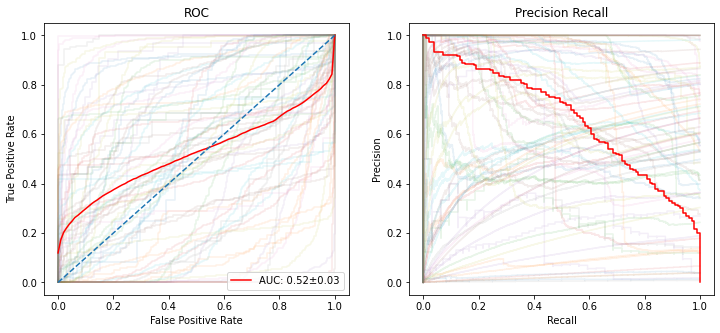

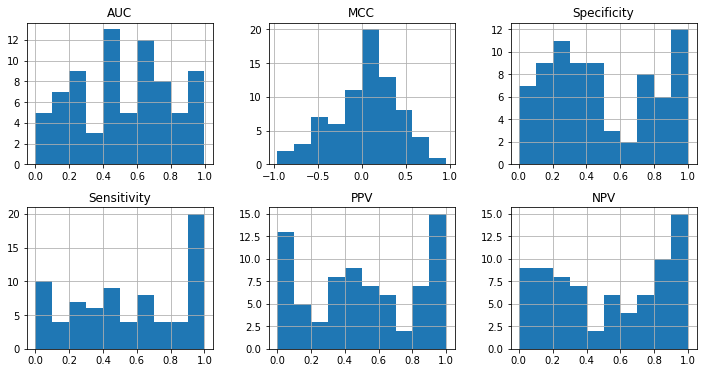

In [55]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12,5))

stats = {'AUC':[]
        ,'MCC':[]
        ,'Specificity':[]
        ,'Sensitivity':[]
        ,'PPV':[]
        ,'NPV':[]}

roc_curves = []
prec_rec_curves = []

for idx, row in tqdm(results.iloc[:].iterrows()):

    probs = row['BLR_Posterior'].mean(axis=1)
    #probs = row['BLR_Posterior'].apply(weighted, axis=1)

    true = row['y_test']#[:,0]

    preds = np.array([1 if el > 0.5 else 0 for el in probs])

    fpr, tpr, thresh = roc_curve(true, probs);
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax1, alpha=0.1)

    roc_curves.append(np.interp(np.linspace(0,1,100), fpr, tpr))

    #ax2.plot(fpr_u, tpr_u, label='unweighted')
    ax1.set_title("ROC")

    prec, recall, _ = precision_recall_curve(true, probs)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax2, alpha=0.1)
    ax2.set_title("Precision Recall")
    prec_rec_curves.append(np.interp(np.linspace(0,1,100), prec, recall))

    cm = confusion_matrix(true, preds)
    tn, fp, fn, tp = cm.flatten()

    try:
        stats['AUC'].append(roc_auc_score(true, probs))

    except ValueError as e:
        continue
    stats['MCC'].append(((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
    stats['Specificity'].append(tn/(tn+fp))
    stats['Sensitivity'].append(tp/(tp+fn))
    stats['PPV'].append(tp/(tp+fp))
    stats['NPV'].append(tn/(tn+fn))

roc_curves=np.array(roc_curves)
prec_rec_curves=np.array(prec_rec_curves)

#fpr_w, tpr_w, thresh_w = roc_curve(np.concatenate(results['y_test'].values), np.concatenate(results['LR_preds'].values));
#auc = roc_auc_score(np.concatenate(results['y_test'].values), np.concatenate(results['LR_preds'].values))
RocCurveDisplay(fpr=np.linspace(0,1,100), tpr=np.nanmean(roc_curves, axis=0)).plot(ax=ax1, color='r', label=f"AUC: {np.mean(stats['AUC']):.2f}±{sem(stats['AUC']):.2f}")
ax1.plot([0,1],[0,1], ls='--')

if not os.path.exists(f"./plots/{FN.split('/')[-1][:-7]}/BLR"):

    os.makedirs(f"./plots/{FN.split('/')[-1][:-7]}/BLR")

PrecisionRecallDisplay(recall=np.linspace(0,1,100), precision=np.nanmean(prec_rec_curves, axis=0)).plot(ax=ax2, color='r')
plt.savefig(f"./plots/{FN.split('/')[-1][:-7]}/BLR/roc_prec.pdf", bbox_inches='tight')

pd.DataFrame(stats).hist(figsize=(12,6), layout=(2,3));
plt.savefig(f"./plots/{FN.split('/')[-1][:-7]}/BLR/stats.pdf", bbox_inches='tight')






/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value sh

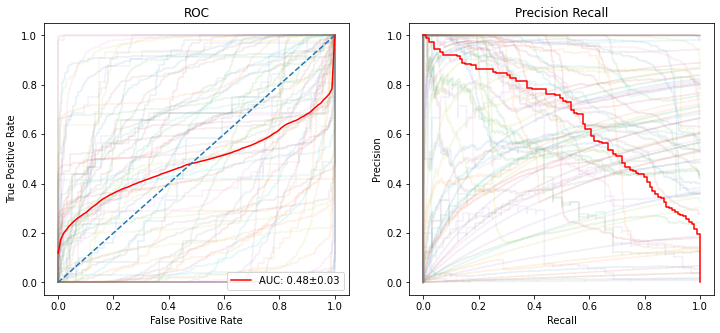

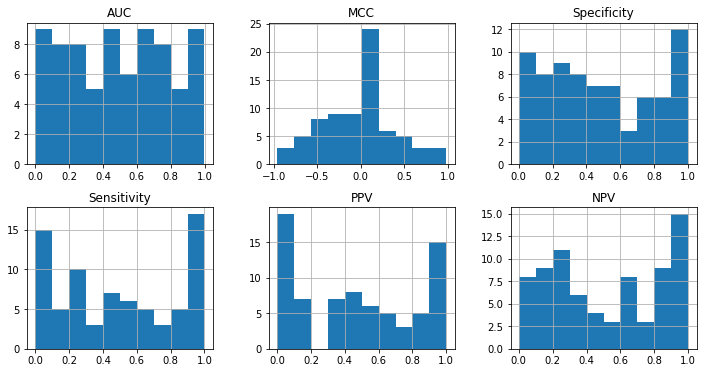

In [56]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12,5))

stats = {'AUC':[]
        ,'MCC':[]
        ,'Specificity':[]
        ,'Sensitivity':[]
        ,'PPV':[]
        ,'NPV':[]}

roc_curves = []
prec_rec_curves = []

for idx, row in results.iloc[:].iterrows():

    probs = row['LR_Preds'].iloc[:,1]
    true = row['y_test']#[:,0]

    preds = [1 if el > 0.5 else 0 for el in probs]

    fpr, tpr, thresh = roc_curve(true, probs);
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax1, alpha=0.1)

    roc_curves.append(np.interp(np.linspace(0,1,100), fpr, tpr))

    #ax2.plot(fpr_u, tpr_u, label='unweighted')
    ax1.set_title("ROC")

    prec, recall, _ = precision_recall_curve(true, probs)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax2, alpha=0.1)
    ax2.set_title("Precision Recall")
    prec_rec_curves.append(np.interp(np.linspace(0,1,100), prec, recall))

    cm = confusion_matrix(true, preds)
    tn, fp, fn, tp = cm.flatten()

    try:
        stats['AUC'].append(roc_auc_score(true, probs))

    except ValueError as e:
        continue
    stats['MCC'].append(((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
    stats['Specificity'].append(tn/(tn+fp))
    stats['Sensitivity'].append(tp/(tp+fn))
    stats['PPV'].append(tp/(tp+fp))
    stats['NPV'].append(tn/(tn+fn))

roc_curves=np.array(roc_curves)
prec_rec_curves=np.array(prec_rec_curves)

#fpr_w, tpr_w, thresh_w = roc_curve(np.concatenate(results['y_test'].values), np.concatenate(results['LR_preds'].values));
#auc = roc_auc_score(np.concatenate(results['y_test'].values), np.concatenate(results['LR_preds'].values))
RocCurveDisplay(fpr=np.linspace(0,1,100), tpr=np.nanmean(roc_curves, axis=0)).plot(ax=ax1, color='r', label=f"AUC: {np.mean(stats['AUC']):.2f}±{sem(stats['AUC']):.2f}")
ax1.plot([0,1],[0,1], ls='--')

if not os.path.exists(f"./plots/{FN.split('/')[-1][:-7]}/LR"):

    os.makedirs(f"./plots/{FN.split('/')[-1][:-7]}/LR")

PrecisionRecallDisplay(recall=np.linspace(0,1,100), precision=np.nanmean(prec_rec_curves, axis=0)).plot(ax=ax2, color='r')
plt.savefig(f"./plots/{FN.split('/')[-1][:-7]}/LR/roc_prec.pdf", bbox_inches='tight')

pd.DataFrame(stats).hist(figsize=(12,6), layout=(2,3));
plt.savefig(f"./plots/{FN.split('/')[-1][:-7]}/LR/stats.pdf", bbox_inches='tight')


In [57]:
thres_results = []

for th in np.arange(20,80,10):

    for i, (idx, row) in tqdm(enumerate(list(results.iterrows()), start=1)):

        try:
            perc = np.percentile(row['BLR_Posterior'].std(axis=1), th)
            indx = np.where(row['BLR_Posterior'].std(axis=1) < perc)[0]

            #indx_s = np.random.randint(0,len(indx), 100)

            preds = row['BLR_Posterior'].iloc[indx, :].mean(axis=1)
            y_true = row['y_test'].values[indx]

            preds = [1 if el > 0.5 else 0 for el in preds]

            thres_results.append({'Threshold': th,
                                'AUC': roc_auc_score(y_true, preds),
                                'Bootstrap':i})
        except IndexError as e:

            print('Index')

        except ValueError as e:

            print(f'Error: {th}')

Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20
Error: 20



Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30
Error: 30



Error: 40
Error: 40
Error: 40
Error: 40
Error: 40
Error: 40
Error: 40
Error: 40
Error: 40
Error: 40
Error: 40
Error: 40
Error: 40
Error: 40
Error: 40
Error: 40
Error: 40
Error: 40
Error: 40
Error: 40
Error: 40
Error: 40
Error: 40
Error: 40
Error: 40



Error: 50
Error: 50
Error: 50
Error: 50
Error: 50
Error: 50
Error: 50
Error: 50
Error: 50
Error: 50
Error: 50
Error: 50
Error: 50
Error: 50
Error: 50
Error: 50
Error: 50
Error: 50
Error: 50
Error: 50
Error: 50
Error: 50
Error: 50
Error: 50
Error: 50



Error: 60
Error: 60
Error: 60
Error: 60
Error: 60
Error: 60
Error: 60
Error: 60
Error: 60
Error: 60
Error: 60
Error: 60
Error: 60
Error: 60
Error: 60
Error: 60
Error: 60
Error: 60
Error: 60
Error: 60
Error: 60
Error: 60
Error: 60
Error: 60



Error: 70
Error: 70
Error: 70
Error: 70
Error: 70
Error: 70
Error: 70
Error: 70
Error: 70
Error: 70
Error: 70
Error: 70
Error: 70
Error: 70
Error: 70
Error: 70
Error: 70
Error: 70
Error: 70
Error: 70
Error: 70
Error: 70
Error: 70
Error: 70



In [58]:
thresh_results=pd.DataFrame(thres_results)
thresh_results.groupby('Threshold')['AUC'].mean()
#thresh_results.groupby('Threshold')['AUC'].mean()/thresh_results.groupby('Threshold')['AUC'].std()

Threshold
20    0.442976
30    0.458529
40    0.475546
50    0.495062
60    0.504114
70    0.514015
Name: AUC, dtype: float64

In [59]:
row['BLR_Posterior'].reset_index()['1yeardeath'].value_counts()

False    1755
True      212
Name: 1yeardeath, dtype: int64

/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value sh

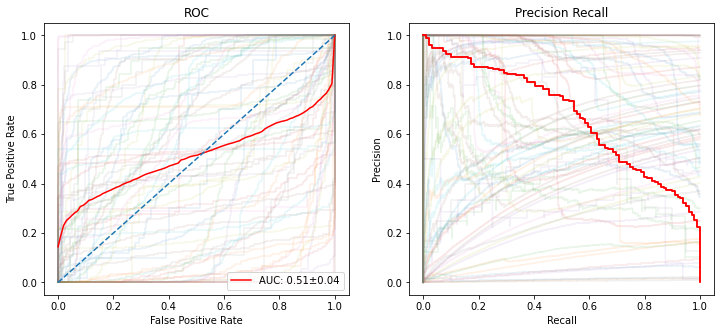

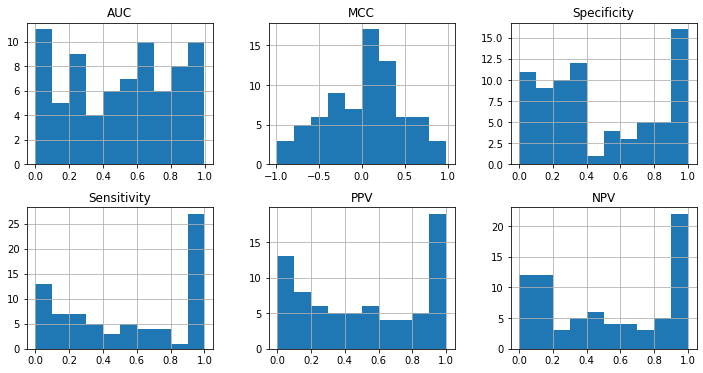

In [60]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12,5))

stats = {'AUC':[]
        ,'MCC':[]
        ,'Specificity':[]
        ,'Sensitivity':[]
        ,'PPV':[]
        ,'NPV':[]}

roc_curves = []
prec_rec_curves = []

for idx, row in results.iloc[:].iterrows():

    # Calculate nth percentile of standard deviations for each prediction
    perc = np.percentile(row['BLR_Posterior'].std(axis=1), 70)

    # Filter based on the percentile value
    indx = np.where(row['BLR_Posterior'].std(axis=1) < perc)[0]

    # Only take predictions and true values for those with the std dev
    # less than that given by the percentile value
    preds = row['BLR_Posterior'].iloc[indx, :].mean(axis=1)
    y_true = row['y_test'].values[indx]

    # Need to check if 0.5 is a suitable value
    predst = np.array([1 if el > 0.5 else 0 for el in preds])

    try:
        fpr, tpr, thresh = roc_curve(y_true, preds);

    except IndexError as e:

        print('index')
        continue
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax1, alpha=0.1)

    roc_curves.append(np.interp(np.linspace(0,1,100), fpr, tpr))

    #ax2.plot(fpr_u, tpr_u, label='unweighted')
    ax1.set_title("ROC")

    prec, recall, _ = precision_recall_curve(y_true, preds)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax2, alpha=0.1)
    ax2.set_title("Precision Recall")
    prec_rec_curves.append(np.interp(np.linspace(0,1,100), prec, recall))


    cm = confusion_matrix(y_true, predst)
    try:
        tn, fp, fn, tp = cm.flatten()
    except:
        continue

    try:
        stats['AUC'].append(roc_auc_score(y_true, preds))
        stats['Specificity'].append(tn/(tn+fp))
        stats['Sensitivity'].append(tp/(tp+fn))
        stats['PPV'].append(tp/(tp+fp))
        stats['NPV'].append(tn/(tn+fn))
        stats['MCC'].append(((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))

    except:
        pass

roc_curves=np.array(roc_curves)
prec_rec_curves=np.array(prec_rec_curves)

#fpr_w, tpr_w, thresh_w = roc_curve(np.concatenate(results['y_test'].values), np.concatenate(results['LR_preds'].values));
#auc = roc_auc_score(np.concatenate(results['y_test'].values), np.concatenate(results['LR_preds'].values))
RocCurveDisplay(fpr=np.linspace(0,1,100), tpr=np.nanmean(roc_curves, axis=0)).plot(ax=ax1, color='r', label=f"AUC: {np.mean(stats['AUC']):.2f}±{sem(stats['AUC']):.2f}")
PrecisionRecallDisplay(recall=np.linspace(0,1,100), precision=np.nanmean(prec_rec_curves, axis=0)).plot(ax=ax2, color='r')


ax1.plot([0,1],[0,1], ls='--')

if not os.path.exists(f"./plots/New/{FN.split('/')[-1][:-7]}/BLR_f"):

    os.makedirs(f"./plots/New/{FN.split('/')[-1][:-7]}/BLR_f")

PrecisionRecallDisplay(recall=np.linspace(0,1,100), precision=np.nanmean(prec_rec_curves, axis=0)).plot(ax=ax2, color='r')
plt.savefig(f"./plots/New/{FN.split('/')[-1][:-7]}/BLR_f/roc_prec.pdf", bbox_inches='tight')

pd.DataFrame(stats).hist(figsize=(12,6), layout=(2,3));
plt.savefig(f"./plots/New/{FN.split('/')[-1][:-7]}/BLR_f/stats.pdf", bbox_inches='tight')
